In [60]:
import pandas as pd
import numpy as np
import datetime

In [2]:
#read in the pre-processed training and test set from Dmitri's notebook
X_train = pd.read_csv("data/X_train_random_1592018748.csv")
Y_train = pd.read_csv("data/Y_train_random_1592018748.csv")
X_test = pd.read_csv("data/X_test_random_1592018748.csv")
Y_test = pd.read_csv("data/Y_test_random_1592018748.csv")

In [4]:
assert((X_train.shape[0] == Y_train.shape[0]) & (X_test.shape[0] == Y_test.shape[0]))

In [7]:
print(f'Dim of X_train: {X_train.shape}')
print(f'Dim of Y_train: {Y_train.shape}')
print("\n")
print(f'Dim of X_test: {X_test.shape}')
print(f'Dim of Y_test: {Y_test.shape}')

Dim of X_train: (1076080, 87)
Dim of Y_train: (1076080, 2)


Dim of X_test: (269020, 87)
Dim of Y_test: (269020, 2)


In [18]:
print(f'Train-test split: [{X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])},\
{X_test.shape[0]/(X_train.shape[0] + X_test.shape[0])}]')

Train-test split: [0.8,0.2]


In [30]:
X_train.columns

Index(['Unnamed: 0', 'application_type', 'grade', 'sub_grade', 'term',
       'initial_list_status', 'emp_length', 'verification_status', '_has_desc',
       'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'fico_range_low',
       'delinq_2yrs', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       '_credit_hist', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA',
       'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL',
       'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA',
       'addr

In [115]:
##we need to get fields needed for return calculations.
LC_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

/Users/rknatuahene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
ret_df = LC_df[["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt", "recoveries"]].copy()

In [117]:
del LC_df ##free me some space


In [118]:
ret_df.term.value_counts(dropna=False)

 36 months    1609754
 60 months     650914
NaN                33
Name: term, dtype: int64

In [119]:
ret_df.dropna(subset=["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt"], inplace=True)

In [120]:
#convert term field to integer months
ret_df['term'] = ret_df['term'].apply(lambda t: np.int8(t.split()[0]))
ret_df.term.value_counts()


36    1607966
60     650275
Name: term, dtype: int64

In [121]:
ret_df[["total_pymnt", "funded_amnt", "recoveries"]].describe().T

,count,mean,std,min,25%,50%,75%,max
total_pymnt,2258241.0,12094.073850,9900.144164,10.0,4560.85,9343.69,16951.677553,63296.877917
funded_amnt,2258241.0,15041.772723,9186.916012,500.0,8000.00,12875.00,20000.000000,40000.000000
recoveries,2258241.0,142.565584,743.233625,0.0,0.00,0.00,0.000000,39859.550000


In [122]:
#convert issue_d and last_pymnt_d into datetime
ret_df['issue_d'] = ret_df['issue_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())
ret_df['last_pymnt_d'] = ret_df['last_pymnt_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())

In [123]:
#calculate the realized term of the loan in months. 
ret_df['realized_loan_term_mths'] = round((ret_df['last_pymnt_d'] - ret_df['issue_d'])/np.timedelta64(1, 'M'))

In [124]:
#where realized_loan_term_mths != term means default or pre-payment
np.sum(ret_df.realized_loan_term_mths != ret_df.term)/ret_df.shape[0]

0.9240351229120364

In [125]:
#remove rows where realized_loan_term_mths = 0
ret_df = ret_df[ret_df.realized_loan_term_mths > 0]

8965

Function calc_return(....)

    calculate the effective(realized) annualized return on the funded amount of a loan
    assumption 1: monthly cash flow can be invested at a monthly rate of return rr
    This assumption allows us to simplify the return calculation to a sum of a geometric series
    with cash payments of: m, m(1+rr), m(1+rr)^2, m(1+rr)^3, ...,m(1+rr)^(last_pymnt_d -1) at the 
    end of months: 0,1,2,3,...last_pyment_d - 1 respectively
    The sequence of cash flows then forms a geometric series of the form
                                        a + ar + ar2 + ... + ar(n-1)
                                        which has a closed form sum:
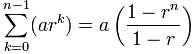

    where r = (1+rr) and a = m, the effective monthly installment payment over the actual life of the loan.
    
    assumption 2: when loan terminates early(due to default or pre-payment) total cash received
    + accrued interest are re-invested at the same rate rr from that time till the term of the loan

In [126]:
def calc_return(total_pymnt, term, funded_amnt, recoveries, realized_loan_term_mths, rr=0.01):
    effective_monthly_installments = (total_pymnt - recoveries)/realized_loan_term_mths
    
    #get total cash flow at loan termination as the geometric sum of effective monthly installments
    #yielding a constant rate of return rr.
    #This is from assumption #1
    total_cash_flow = effective_monthly_installments * ((1 - (1 + rr)**realized_loan_term_mths)) / (1 - (1 + rr))
    
    #add back recoveries to the get the lump sum at loan termination.
    total_cash_flow+= recoveries 

    #assumption #2. invest at rr till original term of loan.
    total_cash_flow = total_cash_flow * ((1 + rr)**(max(0,term - realized_loan_term_mths)))
    
    #calculate return and annualize
    return((12/term) * ((total_cash_flow - funded_amnt) / funded_amnt))


In [127]:
rr = 0.01
ret_df["annualized_returns"] = ret_df.apply(lambda row: calc_return(row[3], row[4], row[5], row[6], row[7], rr), axis =1)

In [128]:
ret_df.shape

(2249276, 9)

In [151]:
ret_df = ret_df.astype({'id': 'int64'})


In [161]:
ret_df.sample(10)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,realized_loan_term_mths,annualized_returns
1403663,143978151,2018-11-01,2019-03-01,3116.700000,36,15000.0,0.0,4.0,-0.236667
735604,76234877,2016-04-01,2018-11-01,10953.861242,36,10000.0,0.0,31.0,0.113960
1126835,36129482,2014-11-01,2015-07-01,9381.950000,36,8800.0,0.0,8.0,0.152990
1669184,101921341,2017-03-01,2019-03-01,18271.270000,60,35000.0,0.0,24.0,-0.032110
2089327,123933527,2017-11-01,2019-03-01,9108.320000,60,21600.0,0.0,16.0,-0.059064
1799374,7284591,2013-10-01,2016-10-01,8962.054003,36,7800.0,0.0,36.0,0.124949
235221,53465013,2015-07-01,2016-12-01,21222.550979,36,20000.0,0.0,17.0,0.129942
2182264,94191432,2016-12-01,2019-03-01,2285.930000,36,2200.0,0.0,27.0,0.099074
662279,81476375,2016-06-01,2019-03-01,12131.090000,36,12000.0,0.0,33.0,0.075599
665107,81910323,2016-06-01,2019-03-01,3433.190000,36,3025.0,0.0,33.0,0.125764
